# Проект курса "Принятие решений в бизнесе на основе данных" #

# Описание проекта #

Мы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Задача:** 
1. Произвести приоритизацию гипотез применив фреймворки ICE и RICE.
2. Проанализировать A/B-тест, сделать вывод и дать рекомендации по дальнейшим действиям в рамках тестирования.

**Описание данных**

***Данные для первой части проекта***

1. Файл /datasets/hypothesis.csv. 
        •	Hypothesis — краткое описание гипотезы;
        •	Reach — охват пользователей по 10-балльной шкале;
        •	Impact — влияние на пользователей по 10-балльной шкале;
        •	Confidence — уверенность в гипотезе по 10-балльной шкале;
        •	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

***Данные для второй части проекта***

2. Файл /datasets/orders.csv. 
       •	transactionId — идентификатор заказа;
       •	visitorId — идентификатор пользователя, совершившего заказ;
       •	date — дата, когда был совершён заказ;
       •	revenue — выручка заказа;
       •	group — группа A/B-теста, в которую попал заказ.

3. Файл /datasets/visitors.csv. 
       •	date — дата;
       •	group — группа A/B-теста;
       •	visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**План работы:**
1. Подготовка данных
2. Предобработка данных
3. Приоритизация гипотез
4. Анализ А/В теста
5. Выводы

## Подготовка данных ##

### Импортируем библиотеки ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import seaborn as sns
from IPython.display import display
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)
import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_colwidth', -1)

### Читаем файлы, сохраняем в датафреймы ###

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')    

## Предобработка данных ##

In [4]:
#посмотрим информацию о датафреймах и сами данные
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
# приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Данная таблица имеет малый размер и полностью представлена на обозрение, поэтому не требует каких-либо проверок и изменений.

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
# проверим наличие дубликатов
orders.duplicated().sum()

0

In [10]:
# приобразуем формат столбца date из object в формат date 
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
#проверим наличие дубликатов
visitors.duplicated().sum()

0

In [14]:
# приобразуем формат столбца date из object в формат date 
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Вывод ###

Представленные таблицы изучены, данные приведены к необходимому виду:

1. В данных пропусков и дубликатов не обнаружено
2. Преобразованы столбцы date в DF orders и visitors в формат даты
3. Столбцы DF hypothesis приведены к нижнему регистру

## Приоритизация гипотез ##

### Фреймворк ICE ###

In [15]:
# расчитаем оценку каждой гипотезы в соответствии с фреймворком ICE
# применим формулу расчета ICE = Impact * Confidence / Efforts
# добавим столбец с оценкой округленной до 2 знака после точки
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


В пятерку лидеров вошли гипотезы с номерами 8, 0, 7, 6, 2. 

### Фреймворк RICE ###

In [16]:
# расчитаем оценку каждой гипотезы в соответствии с фреймворком RICE
# применим формулу расчета RICE = Reach * Impact * Confidence / Efforts
# добавим столбец с оценкой округленной до 2 знака после точки
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Пятерка лидеров состоит из тех же гипотез, но в другом порядке - 7, 2, 0, 6, 8.

In [17]:
# скомпонуем общую таблицу с фреймворками
hypothesis['ice_rank'] = hypothesis['ice'].rank(ascending=False).astype('int')
hypothesis['rice_rank'] = hypothesis['rice'].rank(ascending=False).astype('int')
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice,ice_rank,rice_rank
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20,1,5
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00,2,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00,3,1
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00,4,3
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00,5,2
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00,6,7
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00,7,7
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00,8,6
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00,9,9


### Вывод ###

1. Видим смещение с 1 места на 5 гипотезы "Запустить акцию, дающую скидку на товар в день рождения"  после добавления в расчет параметра reach (охват пользователей = 1) не смотря на высокие оценки на эффекта от изменения (impact =9) и уверенность в гипотезе (confidence=9). 
2. Второе смещение вниз с 2 на 3 место у гипотезы "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", т.к. охват пользователей оценивается в 3 баллка из 10 (что говорит о неуверенности в охвате большой аудитории пользователе - 30%).
3. Гипотезы с 6 по 9 место по ice_rank после добавления в расчет параметра охвата пользователей не поднялись выше 6 места т.к. совокупность 4 параметров в формуле расчета RICE не дает резкого увеличения результата.
4. На 3 место с 4 перемещается гипотеза "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" - это связано с высокой оценкой охвата пользователей, низким уровнем затрат на реализацию задуманного и высокой уверенностью в гипотезе.
5. На 2 место с 5 поднимается гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" из-за оценки охвата пользователей в 8 балов при низком значении делителя (efforts=8).
6. Первое место с 2-х кратным отрывом от всех занимает гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - охватим всех пользователей кто получает рассылку, с высоким уровнем влияния на пльзователя и уверенности в гипотезе при среднем уровне затрат на реализацию. 

## Анализ А/В теста ##

Проверим наличие пользователей в обейх группах теста.

In [18]:
orders.head()
print(f"Количество заказов в группах: {orders[orders.group != 1]['transactionId'].sum()}")
print(f"Выручка от заказов в группах: {orders[orders.group != 1]['revenue'].sum()}")

Количество заказов в группах: 2580278798479
Выручка от заказов в группах: 9992563


In [19]:
duplicate = orders.groupby(['visitorId']).agg({'group':'nunique', 'transactionId':'count', 'revenue':'sum'}).reset_index()
print(f"Количество дублей в группах: {duplicate[duplicate.group != 1]['visitorId'].count()}")
print(f"Количество заказов дублей в группах: {duplicate[duplicate.group != 1]['transactionId'].sum()}")
print(f"Выручка от заказов дублей в группах: {duplicate[duplicate.group != 1]['revenue'].sum()}")

Количество дублей в группах: 58
Количество заказов дублей в группах: 181
Выручка от заказов дублей в группах: 1558935


Так как пользователь совершили покупки на обеих версиях приложения и их данные составляют менее 0,0001 от общего исследуемого параметра то можем удалить данные дубли.

In [20]:
# удавяем дубликаты из DF 
new_duplicate = list(duplicate[duplicate.group != 1]['visitorId'])
orders = orders.query('visitorId not in @new_duplicate')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


### Построим график кумулятивной выручки по группам. ###

In [21]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [22]:
# создадим DF с 2 столбцами date, group
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [23]:
# получаем агрегированные кумулятивные данные по дням о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(\
                   orders['date'] <= x['date'], orders['group'] == x['group'])].agg({\
                    'date':'max', 'group':'max', 'transactionId': pd.Series.nunique, 'visitorId': pd.Series.nunique,\
                    'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

In [24]:
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


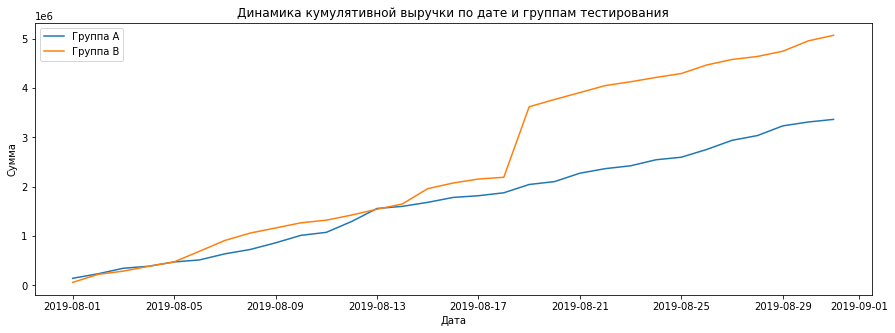

In [25]:
# построим график динамики изменения кумулятивной выручки по дате и группам А/В тестирования
plt.figure(figsize=(15,5))
plt.title('Динамика кумулятивной выручки по дате и группам тестирования')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Сумма', fontsize=10)
plt.plot(ordersAggregated[ordersAggregated['group'] == 'A']['date'],\
         ordersAggregated[ordersAggregated['group'] == 'A']['revenue'], label='Группа А')
plt.plot(ordersAggregated[ordersAggregated['group'] == 'B']['date'],\
         ordersAggregated[ordersAggregated['group'] == 'B']['revenue'], label='Группа В')
plt.legend()
plt.show()

***Вывод***

Выручки в группах непрерывно растут. Выручка от группы В на протяжении всего периода теста имеет незначительное превышение над выручкой группы А.
Скачок выручки 17.08.2019 группы В необходимо рассмотреть отдельно (это может быть большой заказ на сумму превышающую среднюю, рекламная акция в этот день а в группе был заинтересованный пользователь и т.д.). 

### График кумулятивного среднего чека по группам теста ###

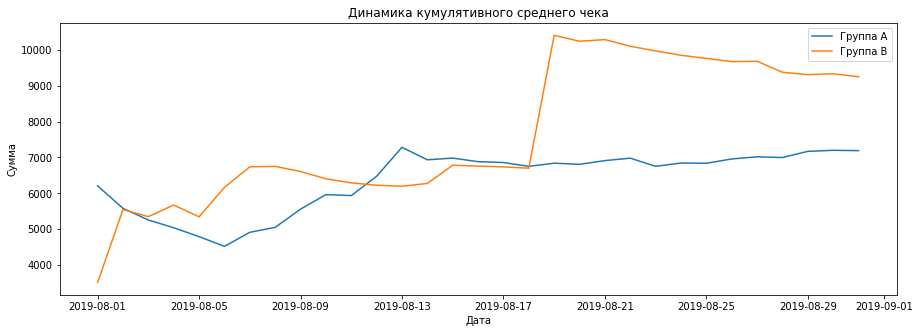

In [26]:
# Простроим график изменения среднего чека
plt.figure(figsize=(15,5))
plt.title('Динамика кумулятивного среднего чека')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Сумма', fontsize=10)
plt.plot(ordersAggregated[ordersAggregated['group'] == 'A']['date'],\
         ordersAggregated[ordersAggregated['group'] == 'A']['revenue']\
         / ordersAggregated[ordersAggregated['group'] == 'A']['transactionId'], label='Группа А')

plt.plot(ordersAggregated[ordersAggregated['group'] == 'B']['date'],\
         ordersAggregated[ordersAggregated['group'] == 'B']['revenue']\
         / ordersAggregated[ordersAggregated['group'] == 'B']['transactionId'], label='Группа В')
plt.legend()
plt.show()

***Вывод***

1. В начале теста в течении 5 дней имеет рост чека группы В с незначительным снижением 4.08 и падение размера чека группы А до 6.08.  
2. С 6.08 средний чек группы А в течении 5 дней имеет такой же по количеству рост как и у группы В с 1.08 по 7.08 и тоже протяженностью 7 дней. Предположим какое то событие отложило покупки группы А на 5 дней.
3. 17.08.2017 происходит резкий рост среднего чека группы В с 7000 до 10000 y.е - возможные причины такого роста - пришли новые клиенты, крупный заказ.
4. В оставшийся период с 17 по 31.08 наблюдаем движение чека группы А в сторону незначительного роста и такое же движение чека группы В в сторону снижения. С течением времени средний чек группы В должен стабилизироваться возле реального среднего чека.

### График относительного изменения кумулятивного среднего чека группы В к группе А ###

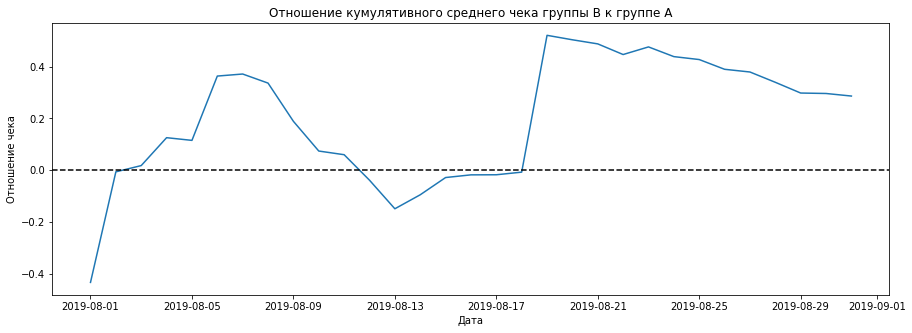

In [27]:
# создадим датафрейм с кумулятивными данными для обеих групп
cumulativeRevenueA = ordersAggregated[ordersAggregated['group'] == 'A'][['date', 'revenue', 'transactionId']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['group'] == 'B'][['date', 'revenue', 'transactionId']]
cumulative_revenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date', how='left', suffixes=['A','B'])
# строим отношение средних чеков
plt.figure(figsize=(15,5))
plt.title('Отношение кумулятивного среднего чека группы В к группе А')
plt.plot(cumulative_revenue['date'],\
         ((cumulative_revenue['revenueB'] / cumulative_revenue['transactionIdB'])/\
         (cumulative_revenue['revenueA'] / cumulative_revenue['transactionIdA']) -1))
plt.xlabel('Дата')
plt.ylabel('Отношение чека')
# Добавляем ось Х
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

***Вывод***

Рост чека группы В в начале теста с 1 по 4.08 скорее всего обусловлено привлечением внимания пользователей при введении какого-то обновления. Дальше чек подрос и начал снижение где 11.08 пересек нулевую линию . С 13.08 начинается рост отношения чека В группы к чеку А группы и 17.08 проходит аномальный рост с плавным снижением в дальнейшем - вероятно надо проанализровать аномальность в данных.

### График кумулятивного среднего количества заказов на посетителя по группам ###

In [28]:
# формируем DF с кумулятивными данными по посетитедлям
visitorsAggregated = datesGroups.apply(\
            lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
                                              visitors['group'] == x['group'])\
                              ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),\
                                     axis=1).sort_values(by=['date', 'group'])

In [29]:
cumulative_data = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'],how='left')
cumulative_data.head()

,date,group,transactionId,visitorId,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [30]:
# добавим столбец с конверсией
cumulative_data['conversion'] = cumulative_data['transactionId'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,transactionId,visitorId,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
1,2019-08-01,B,17,17,59758,713,0.02
2,2019-08-02,A,42,36,234381,1338,0.03
3,2019-08-02,B,40,39,221801,1294,0.03
4,2019-08-03,A,66,60,346854,1845,0.04


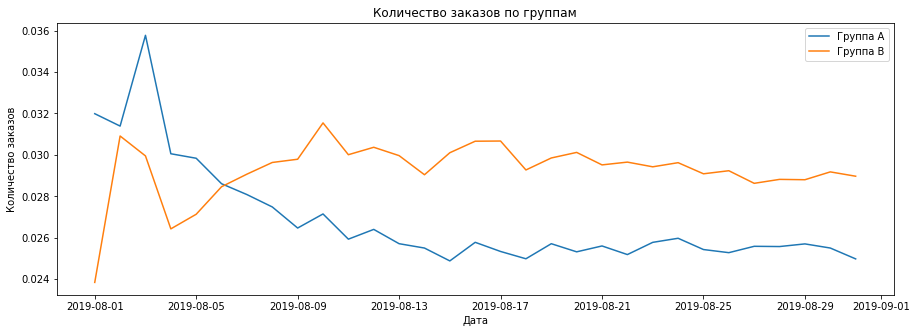

In [31]:
# строим график кумулятивного среднего количества заказов на посетителя
plt.figure(figsize=(15,5))
plt.title('Количество заказов по группам')
plt.plot(cumulative_data[cumulative_data['group'] == 'A']['date'],\
         cumulative_data[cumulative_data['group'] == 'A']['conversion'], label='Группа А')
plt.plot(cumulative_data[cumulative_data['group'] == 'B']['date'],\
         cumulative_data[cumulative_data['group'] == 'B']['conversion'], label='Группа B')         
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

***Вывод***

В начале периода теста видим колебания количество заказов и после 6.08 количество заказов начинает выравниваться где группа В опережает группу А на 20% - возможно нововведения понравились пользователям.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А ###

In [32]:
# создадим датафрейм с кумулятивными данными для обеих групп
cumulative_dataA = cumulative_data[cumulative_data['group'] == 'A']
cumulative_dataB = cumulative_data[cumulative_data['group'] == 'B']
# соединим два DF
cumulative_conversion_merge = cumulative_dataA[['date', 'conversion']]\
                              .merge(cumulative_dataB[['date', 'conversion']],\
                                    on='date', how='left', suffixes=['A', 'B'])
cumulative_conversion_merge.head()

,date,conversionA,conversionB
0,2019-08-01,0.03,0.02
1,2019-08-02,0.03,0.03
2,2019-08-03,0.04,0.03
3,2019-08-04,0.03,0.03
4,2019-08-05,0.03,0.03


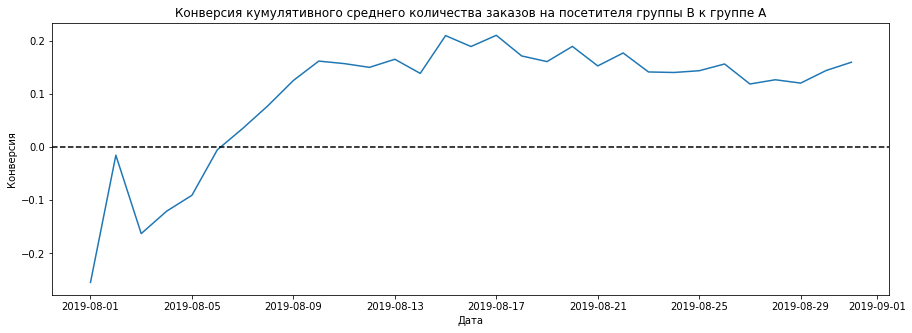

In [33]:
# строим конверсию отношения средних заказов группы В к группе А
plt.figure(figsize=(15,5))
plt.title('Конверсия кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.plot(cumulative_conversion_merge['date'],\
         (cumulative_conversion_merge['conversionB'] / cumulative_conversion_merge['conversionA']-1))
plt.xlabel('Дата')
plt.ylabel('Конверсия')
# Добавляем ось Х
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

***Вывод***

С 6.08 начинается разрыв между конверсиями групп и длится до 17.08.
Отношение конверсии стабилизируется после 18.08 и группа В выигрывает почти на всем протяжении теста.


### Точечный график количества заказов по пользователям ###

In [34]:
# возьмем данные из DF orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [35]:
# формиуем таблицу с пользователями и заказами
ordersByusers = orders.groupby('visitorId', as_index=False)['transactionId'].nunique()
ordersByusers.sort_values(by='transactionId', ascending=False).head()

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


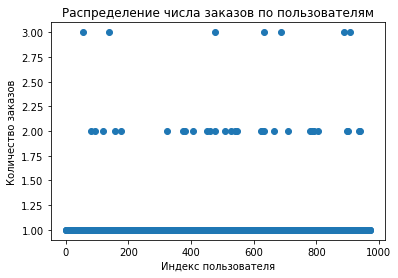

In [36]:
# ось распределения заказов будет длина списка этих заказов
x_values = pd.Series(range(0,len(ordersByusers['transactionId'])))
plt.scatter(x_values, ordersByusers['transactionId']) 
# оформляем график количества заказов по пользователям
plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество заказов')
plt.show()

 ***Вывод***

По графику видим что пользователи совершают один или 2 заказа  - сплошная линия на отметке 1 и почти сплошная на отметке 2. Свыше 2-х заказов совершают уже незначительное количество пользователей - 7. 

### Находим 95-й и 99-й перцентиль количества заказов на пользователя ###

In [37]:
# Посчитаем выборочные перцентили количества заказов на одного пользователя:
print(np.percentile(ordersByusers['transactionId'], [95, 98, 99]))

[1. 2. 2.]


***Вывод***

За все время теста 95% пользователей совершили  2 заказа, 1% пользователей совершили не менее 4 заказов. Выбираем 3 и выше количество заказов на одного пользователя за верхнюю границу числа заказов.

### Точечный график стоимостей заказов ###

In [38]:
# посмотрим DF orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


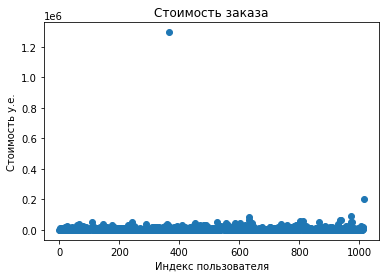

In [39]:
# ось распределения заказов будет длина списка этих заказов
x_values = pd.Series(range(0,len(orders['transactionId'])))
plt.scatter(x_values, orders['revenue']) 
# оформляем график количества заказов по пользователям
plt.title('Стоимость заказа')
plt.xlabel('Индекс пользователя')
plt.ylabel('Стоимость у.е.')
plt.show()

На графике распределения стоимости есть 2 точки (стоимость заказа  свыше 1,2 млн у.е и 0,2 млн у.е).
Данные заказы не позволяют внимательнее изучить область основных заказов и сильно влияют на данные.

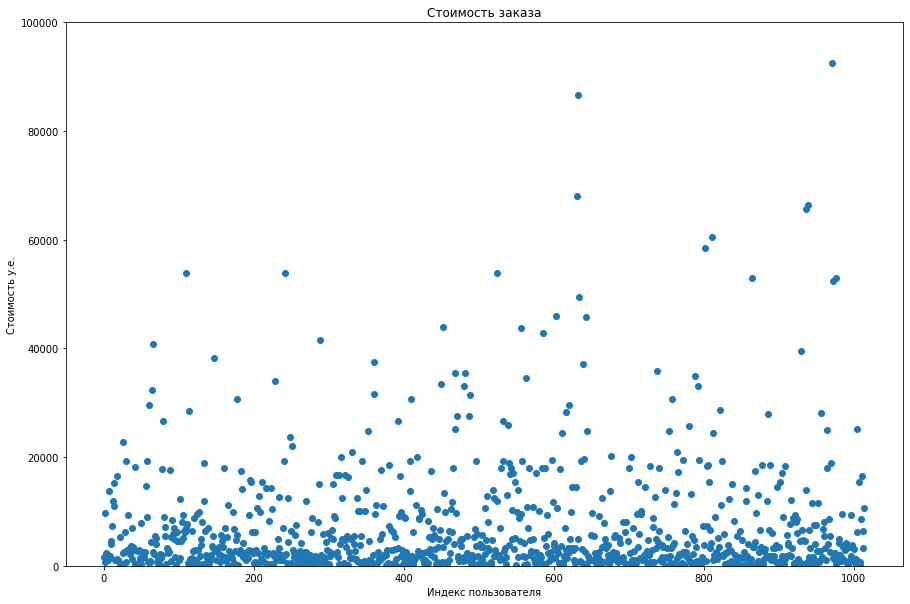

In [40]:
# исключим указанные 2 точки с заказами и построим новый график распределения стоимостей заказов
plt.figure(figsize=(15,10))
plt.title('Стоимость заказа')
plt.ylim(0,100000)
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Индекс пользователя')
plt.ylabel('Стоимость у.е.')
plt.show()

***Вывод***

Удалив 2 выброса данных получили график с данными более наглядно распределенными, что позволяет предположить что данных достаточно для дальнейшего анализа.

### Находим 95-й и 99-й перцентиль стоимости заказов ###

In [41]:
# Посчитаем выборочные перцентили стоимости заказов:
print(np.percentile(orders['revenue'], [95, 96, 97, 98, 99]))

[26785. 30649. 34792. 42353. 53904.]


In [42]:
# посмотрим сколько пользователей совершили покупку на сумму свеше 26785 y.e.
print('{:.2%}'.format(len(orders[orders.revenue > 26785]) / len(orders)))

5.02%


За верхнюю границу выбираем сумму заказа 95 перцентиля равную 26785 у.е., т.к. всего 5% заказов превышают 95 перцентиль.

### Определяем статистическую значимость различий в среднем количестве заказов на посетителя между группами по сырым данным ###

In [43]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [44]:
# подготовим данные сгруппированные по группам А и В
ordersByusers_A = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByusers_B = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

In [45]:
sample_A = pd.concat([ordersByusers_A['transactionId'], pd.Series\
                    (0, index=np.arange(visitors[visitors['group'] == 'A']\
                    ['visitors'].sum() - len(ordersByusers_A['transactionId'])), name='transactionId')], axis=0)
sample_B = pd.concat([ordersByusers_B['transactionId'], pd.Series\
                    (0, index=np.arange(visitors[visitors['group'] == 'B']\
                    ['visitors'].sum() - len(ordersByusers_B['transactionId'])), name='transactionId')], axis=0)

***формулируем гипотезу***
1. нулевая гипотеза (Н0): между конверсией 2-х групп нет статистически значимой разницы
2. гипотеза(Н1): между конверсиями есть статистически значимая разница

In [46]:
print("Вероятность получения различия случайно: {0:.2f}%".format(stats.mannwhitneyu\
                    (sample_A, sample_B, alternative = 'two-sided')[1]*100))
print('Прирост среднего количества заказов для группы В:{0:.2f}%'.format((sample_B.mean() / sample_A.mean() -1)*100))

Вероятность получения различия случайно: 1.10%
Прирост среднего количества заказов для группы В:15.98%


In [47]:
alpha = 0.05
if stats.mannwhitneyu(sample_A, sample_B, alternative = 'two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')    

Отвергаем нулевую гипотезу


***Вывод***

По сырым данным статистическая значимость показывает отрыв в среднем количестве заказов на посетителя на 16,96%  группы В от А.

### Определяем статистическую значимость различий в среднем чеке заказа  между группами по сырым данным ###

***формулируем гипотезу***
1. нулевая гипотеза (Н0): между средними чеками 2-х групп нет статистически значимой разницы
2. гипотеза(Н1): между средними чеками есть статистически значимая разница

In [48]:
print("Вероятность получения различия случайно: {0:.2f}%".format(stats.mannwhitneyu\
                    (orders[orders['group'] == 'A']['revenue'],\
                    orders[orders['group'] == 'B']['revenue'], alternative = 'two-sided')[1]*100))
print('Прирост конверсии чека для группы В:{0:.2f}%'.format((orders[orders['group'] == 'B']['revenue'].mean()\
                                                        / orders[orders['group'] == 'A']['revenue'].mean() -1)*100))

Вероятность получения различия случайно: 82.95%
Прирост конверсии чека для группы В:28.66%


In [49]:
alpha = 0.05
if stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'],\
                      alternative = 'two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')    

Не получилось отвергнуть нулевую гипотезу


***Вывод***


По сырым данным наблюдаем различие среднего чека группы В и А в 28,66% что не является статистически значимым.

### Определяем статистическую значимость различий в среднем количестве заказов на посетителя  между группами по очищенным данным ###

In [50]:
# очистим данные от аномалий
revenue_lim = 26785
orders_transaction = ordersByusers[ordersByusers['transactionId'] > 3]['visitorId']
orders_revenue = orders[orders['revenue'] > revenue_lim]['visitorId']
# объединим данные и очистим от дубликатов
new_date = pd.concat([orders_transaction, orders_revenue], axis=0).drop_duplicates()
print('Количество пользователей с аномальными заказами', len(new_date))

Количество пользователей с аномальными заказами 51


In [51]:
# сформируем семплы для анализа выборки
sample_A = pd.concat([ordersByusers_A[np.logical_not(ordersByusers_A['visitorId'].isin(new_date))]\
                      ['transactionId'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum()\
                      - len(ordersByusers_A['transactionId'])), name='transactionId')], axis=0)
sample_B = pd.concat([ordersByusers_B[np.logical_not(ordersByusers_B['visitorId'].isin(new_date))]\
                      ['transactionId'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum()\
                      - len(ordersByusers_B['transactionId'])), name='transactionId')], axis=0)

***формулируем гипотезу***
1. нулевая гипотеза (Н0): между конверсией 2-х групп нет статистически значимой разницы
2. гипотеза(Н1): между конверсиями есть статистически значимая разница

In [52]:
print("Вероятность получения различия случайно: {0:.2f}%".format(stats.mannwhitneyu\
                    (sample_A, sample_B, alternative = 'two-sided')[1]*100))
print('Прирост среднего количества заказов для группы В:{0:.2f}%'.format((sample_B.mean() / sample_A.mean() -1)*100))

Вероятность получения различия случайно: 1.68%
Прирост среднего количества заказов для группы В:15.56%


In [53]:
alpha = 0.05
if stats.mannwhitneyu(sample_A, sample_B, alternative = 'two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


***Вывод***

Можем сказать что на очищенных данных существует статистически значимая разница в 15,56% в среднем количестве заказов на посетителя между группами.

### Определяем статистическую значимость различий в среднем чеке заказа  между группами по очищенным  данным ###

In [54]:
# исключим аномальных пользователей из сравнительных выборок
print("Вероятность получения различия случайно: {0:.2f}%".format(stats.mannwhitneyu\
        (orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(new_date)))]['revenue'],\
                    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId']\
                    .isin(new_date)))]['revenue'], alternative = 'two-sided')[1]*100))
print('Прирост среднего чека группы В:{0:.2f}%'.format(orders[np.logical_and(orders['group'] == 'B', \
                    np.logical_not(orders['visitorId'].isin(new_date)))]['revenue'].mean() /\
                   orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(new_date)))]\
                                                       ['revenue'].mean()))

Вероятность получения различия случайно: 74.13%
Прирост среднего чека группы В:0.95%


***формулируем гипотезу***
1. нулевая гипотеза (Н0): между средними чеками 2-х групп нет статистически значимой разницы
2. гипотеза(Н1): между средними чеками есть статистически значимая разница

In [55]:
alpha = 0.05
if stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId']\
                                            .isin(new_date)))]['revenue'],\
                      orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId']\
                                            .isin(new_date)))]['revenue'],\
                      alternative = 'two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')   

Не получилось отвергнуть нулевую гипотезу


Вывод
    
Наблюдаемое различие в средних чеках группы В и А в 0,95% не является статистическа значимым.

***Вывод***

P-value увеличился - причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия нет. Средний чек группы B без выбросов стал незначительно выше среднего чека группы A.

### Решение по результатам теста ###

Решение по результатам теста
    
Тест признать успешным и закончить. Результаты статистических тестов показали остутствие статистически значимых различий в среднем чеке между группами (по очищенным данным + 0,95% для группы В), при статистически подтвержденном увеличении количества заказов (по данным + 15,56% для группы В). По резельтатам А\В теста победу одерживает группа В, т.к. при одинаковом среднем чеке но возросших заказах для группы В выручка будет в данный группе расти.

## Вывод ##

**Рекомендации:** 

**Вывод**
    
1. С помощью фреймворков ICE и RICE определили рейтинг гипотез для возможного увеличения выручки:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 
    
    Гипотезы с большим охватом аудитории и меньшими затратами на реализацию поднялись в рейтинге на 2-3 позиции.

2. Анализ различий группы В от группы А  А\В тестом показал:
- А\В тест прошел успешно. Группа В одерживает победу. Совокупность результатов статистических тестов дает увеличение выручки в группе В при  остутствие различий в среднем чеке между группами (по очищенным данным + 0,95% для группы В) и увеличении количества заказов (по данным + 15,56% для группы В).